In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/XAI/Conference

Mounted at /content/drive
/content/drive/MyDrive/XAI/Conference


In [3]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP
!pip install -e .

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/drive/MyDrive/XAI/Conference/CLIP
Obtaining file:///content/drive/MyDrive/XAI/Conference/CLIP
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Running setup.py develop for clip


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

[생성된 캡션]: A style with natural and cool tone and lip focus.


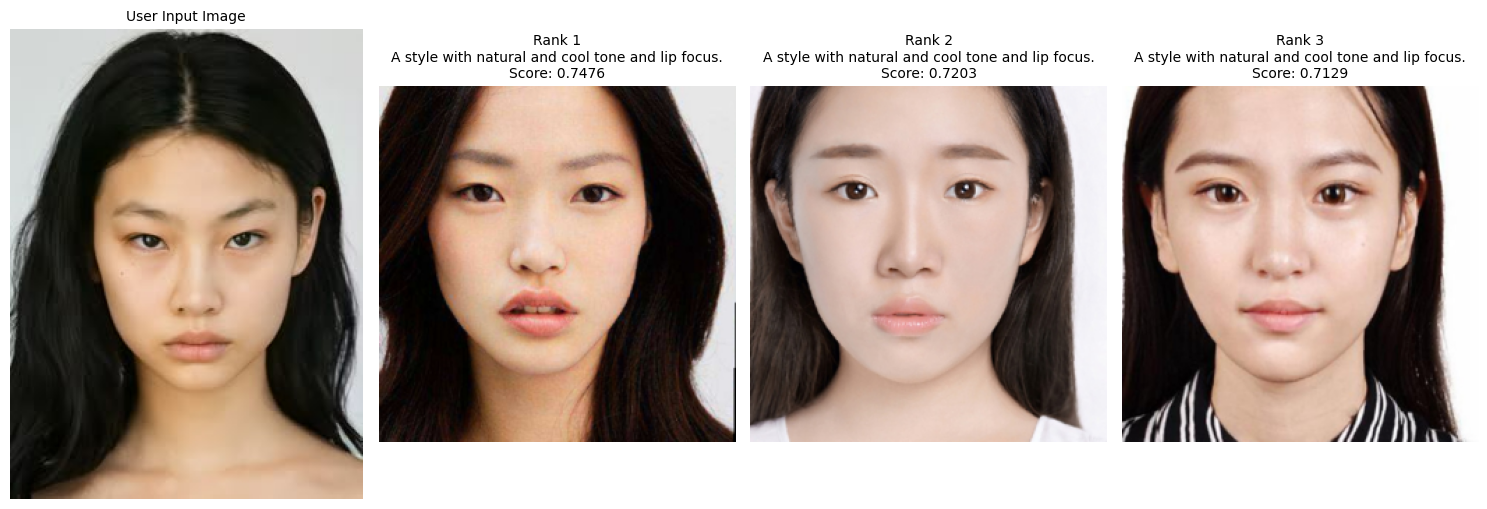

In [2]:
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP 모델 & 프로세서
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ================================
# 1. 사용자 입력
# ================================
user_image_path = "/content/drive/MyDrive/XAI/Conference/face_1.jpg"
user_image = Image.open(user_image_path).convert("RGB")

keywords = ["natural", "cool tone", "lip focus"]
caption = f"A style with {keywords[0]} and {keywords[1]} and {keywords[2]}."
print("[생성된 캡션]:", caption)

# ================================
# 2. 데이터셋 이미지 로드
# ================================
image_folder = "/content/drive/MyDrive/XAI/Conference/triplets_beautygan/src"
image_files = [
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith((".jpg", ".png"))
    and not f.startswith("._")          # MacOS 숨김파일 제외
    and not f.startswith(".DS_Store")   # DS_Store 제외
]

# ================================
# 3. 임베딩 계산
# ================================
# 사용자 이미지 임베딩
user_inputs = processor(images=user_image, return_tensors="pt").to(device)
with torch.no_grad():
    user_image_emb = model.get_image_features(**user_inputs)
    user_image_emb = user_image_emb / user_image_emb.norm(p=2, dim=-1, keepdim=True)

# 텍스트 임베딩
text_inputs = processor(text=[caption], return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_emb = model.get_text_features(**text_inputs)
    text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)

# 이미지+텍스트 결합 (가중합)
alpha, beta = 0.5, 0.5   # 가중치 (텍스트/이미지 반반)
user_query_emb = alpha * user_image_emb + beta * text_emb
user_query_emb = user_query_emb / user_query_emb.norm(p=2, dim=-1, keepdim=True)

# 데이터셋 이미지 임베딩
image_embeddings = []
for img_path in image_files:
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
        emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
    image_embeddings.append(emb)

image_embeddings = torch.cat(image_embeddings, dim=0)

# ================================
# 4. 유사도 계산 및 Top-3 추천
# ================================
similarity = user_query_emb @ image_embeddings.T
k = min(3, similarity.size(1))
topk = similarity.topk(k, dim=1)

# ================================
# 5. 시각화
# ================================
plt.figure(figsize=(15, 5))

# 사용자 입력 이미지 먼저 출력
plt.subplot(1, k+1, 1)
plt.imshow(user_image)
plt.axis("off")
plt.title("User Input Image", fontsize=10)

# 추천 결과 출력
for i, (idx, score) in enumerate(zip(topk.indices[0].tolist(), topk.values[0].tolist())):
    img_path = image_files[idx]
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, k+1, i+2)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Rank {i+1}\n{caption}\nScore: {score:.4f}", fontsize=10)

plt.tight_layout()
plt.show()